In [1]:
#@title Installs
!pip uninstall cupy-cuda115 -q
!pip install cupy-cuda11x -q
!pip3 install scanpy[leiden] -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 MB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 79.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 6.6 MB/s eta 0:00:00


In [2]:
#@title Imports and Set Seed
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype']=42

from matplotlib import font_manager
plt.rcParams['font.size'] = 7

import math
import random
from random import randrange
import itertools

from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset

from google.colab import drive # Import if using Google Colab


def weight_init_seed(seed):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  random.seed(seed)

  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

weight_init_seed(6631)

/usr/local/lib/python3.10/dist-packages/cupy/_environment.py:540: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy-cuda11x, cupy-cuda12x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''


# Create Pseudobulk

In [3]:
# Read in data
t0 = sc.read_10x_h5("/content/example_data/GSM4504959_E12.5_filtered_gene_bc_matrices.h5")
t1 = sc.read_10x_h5("/content/example_data/GSM4504960_E15.5_filtered_gene_bc_matrices.h5")
t2 = sc.read_10x_h5("/content/example_data/GSM4504961_E17.5_filtered_gene_bc_matrices.h5")
t3 = sc.read_10x_h5("/content/example_data/GSM4504962_P3_filtered_gene_bc_matrices.h5")
t4 = sc.read_10x_h5("/content/example_data/GSM4504963_P7_filtered_gene_bc_matrices.h5")
t5 = sc.read_10x_h5("/content/example_data/GSM4504964_P15_filtered_gene_bc_matrices.h5")
t6 = sc.read_10x_h5("/content/example_data/GSM4504965_P42_filtered_gene_bc_matrices.h5")

# Make variale names unique
t0.var_names_make_unique()
t1.var_names_make_unique()
t2.var_names_make_unique()
t3.var_names_make_unique()
t4.var_names_make_unique()
t5.var_names_make_unique()
t6.var_names_make_unique()

t0.var['original_index'] = range(len(t0.var))
t1.var['original_index'] = range(len(t0.var))
t2.var['original_index'] = range(len(t0.var))
t3.var['original_index'] = range(len(t0.var))
t4.var['original_index'] = range(len(t0.var))
t5.var['original_index'] = range(len(t0.var))
t6.var['original_index'] = range(len(t0.var))

# Filter low quality cells and genes
sc.pp.filter_cells(t0, min_genes=100)
sc.pp.filter_cells(t1, min_genes=100)
sc.pp.filter_cells(t2, min_genes=100)
sc.pp.filter_cells(t3, min_genes=100)
sc.pp.filter_cells(t4, min_genes=100)
sc.pp.filter_cells(t5, min_genes=100)
sc.pp.filter_cells(t6, min_genes=100)

sc.pp.filter_genes(t0, min_cells=3)
sc.pp.filter_genes(t1, min_cells=3)
sc.pp.filter_genes(t2, min_cells=3)
sc.pp.filter_genes(t3, min_cells=3)
sc.pp.filter_genes(t4, min_cells=3)
sc.pp.filter_genes(t5, min_cells=3)
sc.pp.filter_genes(t6, min_cells=3)

h5_files = [t0, t1, t2, t3, t4, t5, t6]
pseudo_bulks = []

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_name

In [4]:
# Find common genes (intersection of .var.index across all time points)
common_genes = set(h5_files[0].var.index)
for adata in h5_files[1:]:
    common_genes.intersection_update(adata.var.index)

new_gene_series = t0.var.loc[list(common_genes)]
gene_index_list = new_gene_series['original_index'].tolist()

In [6]:
t0 = sc.read_10x_h5("/content/example_data/GSM4504959_E12.5_filtered_gene_bc_matrices.h5")
t1 = sc.read_10x_h5("/content/example_data/GSM4504960_E15.5_filtered_gene_bc_matrices.h5")
t2 = sc.read_10x_h5("/content/example_data/GSM4504961_E17.5_filtered_gene_bc_matrices.h5")
t3 = sc.read_10x_h5("/content/example_data/GSM4504962_P3_filtered_gene_bc_matrices.h5")
t4 = sc.read_10x_h5("/content/example_data/GSM4504963_P7_filtered_gene_bc_matrices.h5")
t5 = sc.read_10x_h5("/content/example_data/GSM4504964_P15_filtered_gene_bc_matrices.h5")
t6 = sc.read_10x_h5("/content/example_data/GSM4504965_P42_filtered_gene_bc_matrices.h5")

t0.var['original_index'] = range(len(t0.var))
t1.var['original_index'] = range(len(t0.var))
t2.var['original_index'] = range(len(t0.var))
t3.var['original_index'] = range(len(t0.var))
t4.var['original_index'] = range(len(t0.var))
t5.var['original_index'] = range(len(t0.var))
t6.var['original_index'] = range(len(t0.var))

sc.pp.filter_cells(t0, min_genes=100)
sc.pp.filter_cells(t1, min_genes=100)
sc.pp.filter_cells(t2, min_genes=100)
sc.pp.filter_cells(t3, min_genes=100)
sc.pp.filter_cells(t4, min_genes=100)
sc.pp.filter_cells(t5, min_genes=100)
sc.pp.filter_cells(t6, min_genes=100)

t0.var_names_make_unique()
t1.var_names_make_unique()
t2.var_names_make_unique()
t3.var_names_make_unique()
t4.var_names_make_unique()
t5.var_names_make_unique()
t6.var_names_make_unique()

old_h5_files = [t0, t1, t2, t3, t4, t5, t6]
h5_files = []
copies = []

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_name

In [7]:
# Make new AnnData objects with common genes
for ti in old_h5_files:
  filtered_X = ti.X.todense()[:, gene_index_list]

  new_adata = ad.AnnData(filtered_X, obs=ti.obs, var=new_gene_series)

  h5_files.append(new_adata)

/usr/local/lib/python3.10/dist-packages/anndata/_core/storage.py:39: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  warnings.warn(msg, ImplicitModificationWarning)


In [8]:
t0, t1, t2, t3, t4, t5, t6 = h5_files

In [9]:
def pseudo_bulk(h5_file):
  '''
  Converts single-cell RNA-seq data from an h5 file to pseudobulk data. This function:

    1. Normalizes each cell's gene expression to a total sum of 10,000.
    2. Sets expression values below 10 to zero, reducing noise.
    3. Normalizes again to adjust the total expression sum post-thresholding.
    4. Computes the average expression across all cells for each gene.
    5. Applies a log transformation (log1p) to the averaged values.

  Parameters
  ----------
  h5_file
      An AnnData object containing single-cell RNA-seq data.

  Returns
  ----------
  pseudobulk_h5_file
      A numpy array containing log-transformed average gene expression values for pseudobulk data.
  '''
  sc.pp.normalize_total(h5_file, target_sum=1e4)  # Normalize single-cell data

  h5_file.X[h5_file.X < 10] = 0  # Threshold at < 10

  sc.pp.normalize_total(h5_file, target_sum=1e4) # Normalize again

  pseudobulk_h5_file = np.asarray(h5_file.X.mean(axis=0)).flatten() # Avg

  pseudobulk_h5_file = np.log1p(pseudobulk_h5_file) # Log1p

  return pseudobulk_h5_file

In [10]:
def create_pseudo_bulk(h5_files):
  '''
  Generates pseudobulk from all time-stamps

  Parameters
  ----------
  h5_file
      An AnnData object containing single-cell RNA-seq data.

  Returns
  ----------
  np.array
      Pseuobulk data from all time-stamps.
  '''
  pseudo_bulks = []
  for h5_file in h5_files:
    pseudo_h5 = pseudo_bulk(h5_file)
    pseudo_bulks.append(pseudo_h5)

  return np.array(pseudo_bulks)

In [11]:
obs_names = {} # For .obs of bulk AnnData object
for i in range(len(h5_files)): # 7
  obs_names[i] = "TimeStamp" + str(i)
obs_frame = pd.DataFrame(list(obs_names.items()), columns=['Index', 'TimeStamp'])

In [12]:
# Create bulk object
bulks = create_pseudo_bulk(h5_files)
bulks_adata = ad.AnnData(bulks, obs=obs_frame, var=h5_files[0].var)
sc.pp.highly_variable_genes(bulks_adata, n_top_genes=6000, subset=True)

/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [13]:
# Add names of files
bulks_adata.obs['files'] = ['GSM4504959_E12.5_filtered_gene_bc_matrices.h5', 'GSM4504960_E15.5_filtered_gene_bc_matrices.h5',
                            'GSM4504961_E17.5_filtered_gene_bc_matrices.h5', 'GSM4504962_P3_filtered_gene_bc_matrices.h5',
                            'GSM4504963_P7_filtered_gene_bc_matrices.h5', 'GSM4504964_P15_filtered_gene_bc_matrices.h5',
                            'GSM4504965_P42_filtered_gene_bc_matrices.h5']

In [14]:
def pick_gene(gene_no, gene_database=bulks_adata):
  """
  Selects and returns expression data for a specific gene across all samples from a gene database.

  Parameters
  ----------
  gene_no
      The index of the gene in the gene database.
  gene_database
      An AnnData object containing gene expression data. The default is `bulks_adata`.

  Returns
  -------
  numpy.ndarray
      An array containing the expression values for the specified gene across all time points.

  """
  return gene_database.X[:, gene_no]

In [15]:
# Look at time series patterns of a selected gene
gene_timeseries = pick_gene(0)
def plot_geneseries(gene):
  length = [x for x in range(len(gene))]
  plt.plot(length, gene)
  plt.xlabel('Time')
  plt.ylabel('Gene Expression')

# plot_geneseries(gene_timeseries)

# Model

### KNN Function
Find neighboring genes

[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

In [16]:
k = 15
k += 1
neighbors = NearestNeighbors(n_neighbors=k) # k = x, x-1 neighbors
neighbors.fit(bulks_adata.X.T)

def find_neighbors(g, neighbors_func=neighbors, gene_database=bulks_adata):
  """
  Finds and returns the indices of the nearest neighbors for a given gene vector in the gene database.

  Parameters
  ----------
  g
      The gene vector for which neighbors are to be found
  neighbors_func
      A fitted NearestNeighbors object from scikit-learn.
      The default is `neighbors`, which should be predefined as a NearestNeighbors object.
  gene_database
      An AnnData object containing gene expression data. The default is `bulks_adata`.

  Returns
  -------
  numpy.ndarray
      An array of indices for the nearest neighbors, excluding the index of the gene vector itself.

  Notes
  -----
  The function assumes `neighbors_func` has been fitted to the gene expression data in `gene_database`.
  Ensure `neighbors_func` is appropriately initialized and fitted outside of this function.

  """
  neighbor_arr = neighbors_func.kneighbors([g])
  return neighbor_arr[1][0][1:]

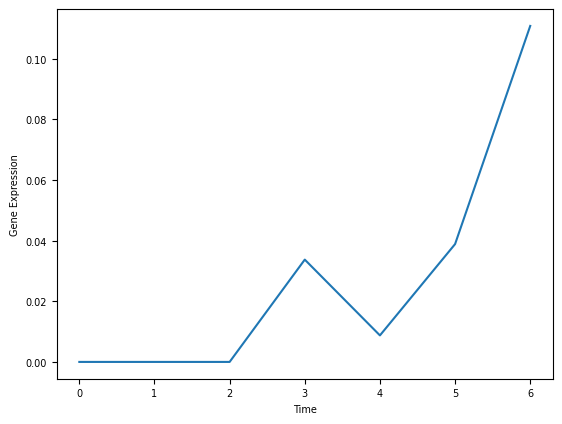

In [17]:
# Check, do the time series looks similar?
gene_0 = pick_gene(0)
gene0_neighbors = find_neighbors(gene_0)
plot_geneseries(pick_gene(gene0_neighbors[1]))

### Data Preprocessing

In [18]:
# Format input for NN
def format_input(g, gene_database=bulks_adata):
  """
  format_input formats the input for the NN. Shape to format: [g1,...,gt,n1,...,nt]

  Parameters
  ----------
  g
    Gene expression values across all time points for single gene g
  gene_database
    Database to pull gene expressions from

  Retuens
  ----------
  input
    Formatted input, with genes and neighbors as features
  """
  neighbors = find_neighbors(g, gene_database=gene_database) # Get indices of all neighbors of g
  input = np.array(g)

  for n in neighbors:
    neighbor_gene = np.array(pick_gene(n))
    input = np.concatenate((input, neighbor_gene), axis=None) # Concat neighbors with original gene

  return input

# gene0 = format_input(pick_gene(0))

In [19]:
all_inputs = [] # All inputs, formatted, not scaled

time_embeddings = [x for x in range(bulks_adata.obs.shape[0])]

for i in range( int(len(bulks_adata.var)) ):
  # Pick gene and format the input
  gene_i = pick_gene(i)
  formatted_input = format_input(gene_i)

  all_inputs.append(formatted_input)

In [22]:
# Masking mechanism
def mask(time_points, input, mask_value=np.NINF, gene_database=bulks_adata):
    """
    Masks specified time points in the input array with a given mask value and returns the modified array along with the original values at the masked positions.

    Parameters
    ----------
    time_points
        Indices of the time points to be masked in the input array. Assumes 0-based indexing.
    input
        The array containing values to be masked.
    mask_value
        The value used to replace the entries at the specified time points. Default is np.NINF (negative infinity).
    gene_database
        An AnnData object containing gene expression data. This is not directly used in the function but included for potential extensions. Default is `bulks_adata`.

    Returns
    -------
    tuple
        A tuple containing two elements:
        1. The modified input array with specific time points replaced by `mask_value`.
        2. An array of the original values at the masked positions.

    Examples
    --------
    >>> input_array = np.array([10, 20, 30, 40, 50])
    >>> time_points_to_mask = [1, 3]
    >>> masked_array, original_values = mask(time_points_to_mask, input_array)
    >>> masked_array
    array([10, -inf, 30, -inf, 50])
    >>> original_values
    array([20, 40])
    """
    new_arr = input.copy()
    max_timepoints = bulks_adata.obs.shape[0]
    masked = []

    first_y = []

    for n in range(len(input)):
      ts_mask = n % max_timepoints

      if ts_mask in time_points: # Mask each time-point for every neighbour
        masked.append(new_arr[n])

        if ts_mask == time_points[0]:
          first_y.append(new_arr[n])

        new_arr[n] = mask_value  # Masked with -inf by default

    new_arr = np.append(new_arr, time_points[0])

    return new_arr, first_y

# test, masked = mask([2, 1, 3], gene0)
# print(gene0)
# print(test, masked)

In [23]:
time_embeddings=[0, 1, 2, 3, 4, 5, 6]

In [24]:
X_train_note, X_test_note = train_test_split(all_inputs, train_size=0.8, shuffle=True) # 80/20 Split all inputs

In [25]:
all_data = [] # Append time embeddings
for i in range(len(X_train_note)):
  all_data.append( np.append(X_train_note[i], time_embeddings) )

for i in range( len(X_test_note) ):
  all_data.append( np.append(X_test_note[i], time_embeddings) )

In [26]:
X_train = []
X_test = []

for i in range(int(len(all_data) * 0.8)): # 80%, 20% split
  X_train.append( all_data[i] )

for i in range(int(len(all_data) * 0.8)+1, len(all_data)):
  X_test.append( all_data[i] )

In [27]:
def generate_combintations(n, time_points=time_embeddings):
  """
    Generates combinations of time point indices where the first element is to be predicted and the rest are masked.
    This function creates permutations of the time points, prioritizing the position of the first element in each combination.

    Parameters
    ----------
    n
        The number of time points to include in each combination.
    time_points
        An array of time point indices available for masking and prediction. The default is `time_embeddings`, which
        should be predefined.

    Returns
    -------
    list of tuples
        A list of combinations, each as a tuple, where the first element of each tuple is the time point to be predicted (and masked),
        and the remaining elements are time points to be masked.
  """
  combinations = []
  to_skip = int(math.factorial(n-1))-1 # Want only permutations where first number is different, skip the rest
  skipped = to_skip

  for comb in itertools.combinations(time_points, n): # Generate combinations of length n
    to_avg = [] # Group together permutations that will be averaged in the end

    for permutation in list(itertools.permutations(comb)): # Generate permutations of those combinations
      if skipped > 0: # Dont want all permutations
        skipped -= 1
        continue

      to_avg.append(list(permutation))

      skipped = to_skip

    combinations.append(to_avg)

    # e.g. combinations[0] has lists of size n. Caluclate MAE for predictions of all of them, take average.

  return combinations
# generate_combintations(3)

In [29]:
def gen_loader(X_train, n):
  """
  Generates a loader containing training batches for a regressor neural network. Each batch
  consists of combinations of data points from the training set, where certain points are masked
  according to specified combinations. This function iterates over the training data, applies
  masking, and constructs batches suitable for regression training.

  Parameters
  ----------
  X_train
      The input training data from which to generate combinations and batches.
  n
      The number of elements in each combination, dictating the structure of the masking.

  Returns
  -------
  list of list of tuples
      A nested list where each inner list contains tuples of masked data and corresponding target values.
      Each tuple represents a training example consisting of a tensor of masked inputs and a tensor of targets.
  """
  X_train_loader = []
  i = 0
  while i < len(X_train)-1:

    for comb in generate_combintations(n):
      loader = []
      for seq in comb:

        if i > len(X_train)-1:
          break

        masked, y = mask(seq, X_train[i])
        masked, y = torch.tensor(masked, dtype=torch.float32), torch.tensor(y[0], dtype=torch.float32)
        arr = [masked, y]

        loader.append(arr)

      X_train_loader.append(loader)
      i += 1

  return X_train_loader

In [30]:
# Initialize empty lists for different loaders
X_train_loader = []
AE_train_loader = []
AE_test_loader = []

# Iterate over each time point
for i in range(1, len(time_embeddings)):
  random.shuffle(X_train)
  gen_i = gen_loader(X_train, i)

  X_train_loader.extend( gen_i )

  random.shuffle(gen_i)

  for j in gen_i[:len(gen_i)//2]:
    AE_train_loader.extend( j )

  random.shuffle(X_test)
  gen_i_test = gen_loader(X_test, i)
  random.shuffle(gen_i_test)

  for t in gen_i_test:
    AE_test_loader.extend( t )

random.shuffle(X_train_loader)
random.shuffle(AE_train_loader)

In [31]:
class GeneDatasetAE(torch.utils.data.Dataset):
  # Characterizes a dataset for PyTorch
  def __init__(self, X):
        self.X = X

  def __len__(self):
        return len(self.X)

  def __getitem__(self, index):
        # Generates one sample of data
        gene = self.X[index]

        return gene

In [32]:
AEgeneTrainSet = GeneDatasetAE(AE_train_loader)
AE_train_loader_x = DataLoader(AEgeneTrainSet, shuffle=True, batch_size=3)

AEgeneTestSet = GeneDatasetAE(AE_train_loader)
AE_test_loader_X = DataLoader(AEgeneTestSet, shuffle=True, batch_size=3)

### AutoEncoder + NN

In [33]:
class HybridNN(nn.Module):
  # Class for hybrid NN model
  def __init__(self, input_size, output_size):
      super().__init__()
      self.encoder = nn.Sequential(
          nn.Linear(input_size, 128),
          nn.ReLU(),
          nn.Linear(128, output_size),
      )

      self.decoder = nn.Sequential(
          nn.Linear(output_size, 128),
          nn.ReLU(),
          nn.Linear(128, input_size),
          nn.ReLU()
      )

      self.regressor = nn.Sequential(
          nn.Linear(output_size, 64),
          nn.ReLU(),
          nn.Linear(64, 32),
          nn.ReLU(),
          nn.Dropout(0.2),
          nn.Linear(32, 1),
          nn.ReLU()
      )

  def forward(self, x):
      # AutoEncoder
      z = self.encoder(x)
      decoded = self.decoder(z)

      # Regressor NN
      regression = self.regressor(z)

      return decoded, regression

In [34]:
def custom_loss(y_pred, y, loss_fn):
  """
  Skip over masked values in the calculation. This is done for AE phase
  """
  mask = ~torch.isinf(y) # True if not infinity
  return loss_fn(y_pred[mask], y[mask])

In [39]:
dim_reduction_size = 64
hybrid_model = HybridNN((k+1) * len(time_embeddings) + 1, dim_reduction_size)

loss_MSE = nn.MSELoss() # For AutoEncoder
loss_MAE = nn.L1Loss(reduction='none') # For Regressor

# Stage 1: AE
optimizer_enc = optim.Adam(hybrid_model.encoder.parameters(), lr=0.001, weight_decay=0.0001) # Adam optimizer with learning rate 0.001, weight decay of 0.0001
optimizer_dec = optim.Adam(hybrid_model.decoder.parameters(), lr=0.001, weight_decay=0.0001)

# Stage 2: Regressor
optimizer_reg = optim.SGD(hybrid_model.regressor.parameters(), lr=0.001, momentum=0.9) # SGD optimizer with learning rate 0.001, momentum of 0.9
scheduler_reg = optim.lr_scheduler.ExponentialLR(optimizer_reg, gamma=0.9)

# Stage 3: Both
optimizer_both = optim.SGD(hybrid_model.parameters(), lr=0.0001, momentum=0.9) # Decrease learning rate when training in stage 3
scheduler_both = optim.lr_scheduler.ExponentialLR(optimizer_both, gamma=0.9)

optimizers = [optimizer_enc, optimizer_dec, optimizer_reg, optimizer_both]

In [40]:
def train_hybridNN_0mask(hyb_model, loader1, loader2, optimizers, loss_fn1, loss_fn2, custom_loss, epochs):
  """
  Trains a hybrid neural network model in three distinct phases to optimize different components of the model.
  Each phase targets a specific part of the model with adapted learning objectives and potentially different learning rates.

  Parameters
  ----------
  hyb_model
      The hybrid neural network model to be trained.
  loader1
      The data loader containing training data used in training the autoencoder
  loader2
      The data loader containing training data used in training the regressor
  optimizers
      A list of PyTorch optimizers for different parts of the model
  loss_fn1
      The loss function used for the autoencoder training
  loss_fn2
      The loss function used for the regressor
  custom_loss
      The combined loss function used when training the autoencoder
  epochs
      Total number of epochs over which the model is trained across all phases.

  Steps
  -----
  Train model in 3 phases:
  1. AutoEncoder
  2. Regressor
  3. Both

  Learning rate is decreased in phase 3. Each stage is trained for `epochs` times.
  """
  optimizer_enc, optimizer_dec, optimizer_reg, optimizer_both = optimizers

  epoch_vals = []
  loss_vals = []

  print("AutoEncoder:")

  # -------- Stage 1 --------
  # AutoEncoder Part:
  for epoch in range(epochs):
    hyb_model.train()
    last_loss = 0

    for AE_input, _ in loader1:
      masked_X = torch.nan_to_num(AE_input, nan=0.0, neginf=0.0) # Make all -inf to 0 for forward pass
      reconstructed, _ = hyb_model(masked_X)

      loss = custom_loss(reconstructed, AE_input, loss_fn1) # Calculate MSE only for non-masked values

      optimizer_enc.zero_grad()
      optimizer_dec.zero_grad()

      loss.backward()

      clipping_value = 10
      torch.nn.utils.clip_grad_norm_(hyb_model.parameters(), clipping_value)

      optimizer_enc.step()
      optimizer_dec.step()

      last_loss = loss.item()

    print(f'Epoch {epoch}: Loss = {last_loss}')

  print()
  print("Regressor:")

  # -------- Stage 2 --------
  for epoch in range(epochs):
    hyb_model.train()

    # Freeze AE
    for name, param in hyb_model.named_parameters():
      if "encoder" in name or "decoder" in name:
        param.requires_grad = False

    last_loss = 0

    # Regressor Part:

    for batch in loader2:
      if batch == []:
        continue

      avg_loss = 0
      optimizer_reg.zero_grad()

      for x, y in batch:
        masked_X = torch.nan_to_num(x, nan=0.0, neginf=0.0)
        _, y_pred = hyb_model(masked_X)

        loss = loss_fn2(y_pred, y)
        avg_loss += loss/len(batch)

      avg_loss.backward()

      optimizer_reg.step()
      last_loss = avg_loss.item()

    scheduler_reg.step()
    print(f'Epoch {epoch}: Loss = {last_loss}')

  print()
  print("Both:")

  # -------- Stage 3 --------
  for epoch in range(epochs):
    hyb_model.train()

    # Unfreeze AE
    for name, param in hyb_model.named_parameters():
      if "encoder" in name or "decoder" in name:
        param.requires_grad = True

    for batch in loader2:
      if batch == []:
        continue

      avg_loss_reg = 0
      avg_loss_ae = 0

      optimizer_both.zero_grad()

      for x, y in batch:
        masked_X = torch.nan_to_num(x, nan=0.0, neginf=0.0)
        reconstruction, y_pred = hyb_model(masked_X)

        loss_reg = loss_fn2(y_pred, y)
        avg_loss_reg += loss_reg/len(batch)

        loss_ae = custom_loss(reconstruction, x, loss_fn1)
        avg_loss_ae += loss_ae/len(batch)

      combined_loss = avg_loss_reg + avg_loss_ae
      combined_loss.backward()

      # optimizer.step()
      optimizer_both.step()
      last_loss = combined_loss.item()

    scheduler_both.step()

    print(f'Epoch {epoch}: Loss = {last_loss}')

In [ ]:
train_hybridNN_0mask(hybrid_model, AE_train_loader_x, X_train_loader, optimizers, loss_MSE, loss_MAE, custom_loss, epochs=15)

In [42]:
torch.save(hybrid_model.state_dict(), "hybrid_model.pth")

In [ ]:
# Code to load pretrained model
# hybrid_model = HybridNN((k+1) * len(time_embeddings) + 1, dim_reduction_size)
# hybrid_model.load_state_dict(torch.load("hybrid_model.pth"))

# Measuring Performance

## MAE and $R^{2}$ model analysis

In [43]:
def MAE(pred, y):
  """
  Maen Absolute Error loss
  """
  return abs(pred-y)

In [44]:
def metric_combinationTS(gene_no, metric_func, n, database=all_data, model=hybrid_model, time_points=time_embeddings, printB=False):
  """
  metric_combinationTS calculate performance metric for prediction of combinations hidden time points for single gene in database.
  Prints time points to select for further single cell analysis.

  Parameters
  ----------
  time_points
      How many time points to measure
  metric_func
      Metric function to measure performance (MAE is preferred)
  n
      Length of combinations

  Returns
  -------
  metric_values
      Average value of metric for each hidden time point for all genes
  """

  model.eval()
  gene = database[gene_no]
  max_TS = int(gene[-1])+1

  combinations = generate_combintations(n)

  metric_values = []

  with torch.no_grad():
    for comb in combinations: # Sequence of combinations to average
      combintation_sum = 0 # Sum absolute error of all combinations, then divide by n
      seed = random.random()

      for sequence in comb: # Calculate MAE for each sequence, average them
        masked, y = mask(sequence, gene)
        masked, y = torch.tensor(masked, dtype=torch.float32), torch.tensor(y[0], dtype=torch.float32)

        zeros_X = torch.nan_to_num(masked, nan=0.0, neginf=0.0)
        _, prediction = model(zeros_X)

        metric_measure = metric_func(prediction, y)[0].item() # Measure error using metric_func
        combintation_sum += metric_measure

      avg_combination = combintation_sum/n
      metric_values.append(avg_combination) # Append value of error

      if printB: print(f'{metric_func.__name__} for time point(s) {comb[0]}: {avg_combination}') # Print error value for each time point(s)

  metric_values = np.array(metric_values)

  if printB:
    print(f'Average {metric_func.__name__}: {metric_values.sum()/len(metric_values)}') # Print average value for all time points

    lowest_MAE = combinations[metric_values.argmin()][0]
    print(f'Lowest time point(s): {lowest_MAE}')

  return metric_values


In [ ]:
# ar_24002 = metric_combinationTS(24002, MAE, 2, printB=True) # For one gene

In [45]:
def avg_metric_combinationTS(metric_func, n, model, time_points=len(bulks_adata.obs), database=all_data, number_genes=len(bulks_adata.var), verbose=False):
  """
  avg_metric_combinationTS calculate average performance metric for prediction of combinations hidden time points for every gene in database

  Parameters
  ----------
  time_points
      How many time points to measure
  metric_func
      Metric function to measure performance (MAE is preferred)
  n
      How many time points to mask
  database
      Database to choose genes from
  number_genes
      Total number of genes
  verbose
      Print verbose output, otherwise only shows time points to choose for further analysis

  Returns
  -------
    avg_val
      Array of average value of metric for each hidden time point for all genes
    avg_allTS
      Average value of metric for all genes
  """
  TS_combinations = generate_combintations(n)
  avg_val = np.zeros(len(TS_combinations))

  for i in range(number_genes):
    vals = metric_combinationTS(i, metric_func, n, model=model, database=database, printB=False)
    avg_val += vals

  avg_val = avg_val/number_genes
  avg_allTS = 0

  for t in range(len(avg_val)):
    avg_allTS += avg_val[t]
    print(f'Average {metric_func.__name__} value for all genes at time point {TS_combinations[t][0]}: {avg_val[t]}')

  avg_allTS = avg_allTS/len(avg_val)

  if verbose:
    print()
    print(f'Average {metric_func.__name__} value for all genes: {avg_allTS}')

  lowest_MAE = TS_combinations[avg_val.argmin()][0]
  highest_MAE = TS_combinations[avg_val.argmax()][0]

  if verbose:
    print(f'Lowest time point: {lowest_MAE}')
    print(f'Highest time point: {highest_MAE}')

    print()
  to_choose = [x for x in time_embeddings if x not in lowest_MAE]
  print(f'Time Points to choose for further analysis: {to_choose}')

  return avg_val, avg_allTS

In [ ]:
avg_valarray_1, avg_val_1 = avg_metric_combinationTS(MAE, 1, hybrid_model, verbose=True)

In [ ]:
avg_valarray_2, avg_val_2 = avg_metric_combinationTS(MAE, 2, hybrid_model, verbose=True)

In [ ]:
avg_valarray_3, avg_val_3 = avg_metric_combinationTS(MAE, 3, hybrid_model, verbose=True)

In [ ]:
avg_valarray_4, avg_val_4 = avg_metric_combinationTS(MAE, 4, hybrid_model, verbose=True)

In [ ]:
avg_valarray_5, avg_val_5 = avg_metric_combinationTS(MAE, 5, hybrid_model, verbose=True)

In [ ]:
avg_valarray_6, avg_val_6 = avg_metric_combinationTS(MAE, 6, hybrid_model, verbose=True)

In [ ]:
# Plot Average MAE for all genes vs. number of shown time points
plt.title(f"No. time points shown vs. Average MAE")
plt.plot([1, 2, 3, 4, 5, 6], [avg_val_6, avg_val_5, avg_val_4, avg_val_3, avg_val_2, avg_val_1], color='blue')
plt.xlabel('No. Shown Time Points')
plt.ylabel('Average MAE for all genes')
plt.show()

In [49]:
def correlation_combination_timepoint(n, database=all_data, model=hybrid_model, verbose=False):
  """
  correlation_combination_timepoint calculate correlation for prediction of combinations hidden time points for every gene in database

  Parameters
  ----------
  n
      How many time points to mask
  database
      Database to choose genes from
  model
      Trained model to use
  verbose
      Print verbose output

  Returns
  -------
    r_values
      An array containing the average Pearson's r value for each combination of masked time points across all genes
    avg_r2
      The overall average R-squared value computed across all combinations and all genes
  """
  model.eval()

  combinations = generate_combintations(n)

  r_values = []
  r2_values = []

  with torch.no_grad():
    for comb in combinations:
      r_vals = 0
      r2_vals = 0

      seed = random.random()

      for sequence in comb:
        y_true_seq = np.zeros(len(bulks_adata.var))
        y_pred_seq = np.zeros(len(bulks_adata.var))

        for i in range(len(bulks_adata.var)):
          formatted_input = database[i]

          masked, y = mask(sequence, formatted_input)
          masked, y = torch.tensor(masked, dtype=torch.float32), torch.tensor(y[0], dtype=torch.float32)

          zeros_X = torch.nan_to_num(masked, nan=0.0, neginf=0.0)
          _, prediction = model(zeros_X)

          y_true_seq[i] = y.item()
          y_pred_seq[i] = prediction.item()

        r = scipy.stats.pearsonr(y_true_seq, y_pred_seq)[0]
        r_vals += r
        r2_vals += r**2

      r_values.append(r_vals/len(comb))
      r2_values.append(r2_vals/len(comb))


      if verbose:
        # print(f'R for time point(s) {comb[0]}: {r}')
        print(f'R^2 for time point(s) {comb[0]}: {r**2}')
        print()

  r_values = np.array(r_values)
  r2_values = np.array(r2_values)

  avg_r2 = r2_values.sum()/len(r2_values)

  if verbose: print(f'Average R^2: {avg_r2}')

  return r_values, avg_r2

In [ ]:
r_vals_1, r_avg_1 = correlation_combination_timepoint(1, verbose=True)

In [ ]:
r_vals_2, r_avg_2 = correlation_combination_timepoint(2, verbose=True)

In [ ]:
r_vals_3, r_avg_3 = correlation_combination_timepoint(3, verbose=True)

In [ ]:
r_vals_4, r_avg_4 = correlation_combination_timepoint(4, verbose=True)

In [ ]:
r_vals_5, r_avg_5 = correlation_combination_timepoint(5, verbose=True)

In [ ]:
r_vals_6, r_avg_6 = correlation_combination_timepoint(6, verbose=True)

In [ ]:
# Plot Average R^2 for all genes vs. number of shown time points
plt.title(f"No. time points shown vs. Average R^2")
plt.plot([1, 2, 3, 4, 5, 6], [r_avg_6, r_avg_5, r_avg_4, r_avg_3, r_avg_2, r_avg_1], color='red')
plt.xlabel('No. Shown Time Points')
plt.ylabel('Average R^2 for all genes')
plt.show()

## Single-cell performance analysis using scSemiProfiler

In [ ]:
import pdb,sys,os
import warnings
warnings.filterwarnings('ignore')
import anndata
import scanpy as sc
sc.settings.verbosity = 0
import argparse
import copy
import numpy as np
import scipy
import timeit

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from typing import Tuple
import scSemiProfiler as semi
from scSemiProfiler.utils import *
name = 'single_cell_inference_project_lung_Alveolus_high'
bulk = 'bulk_data_lung_Alveolus.h5ad'
logged = False
normed = False
geneselection = False
batch = 3

t0 = anndata.read_h5ad("single_cell_inference_project_lung_Alveolus_high/sample_sc/t0.h5ad")
t1 = anndata.read_h5ad("single_cell_inference_project_lung_Alveolus_high/sample_sc/t1.h5ad")
t2 = anndata.read_h5ad("single_cell_inference_project_lung_Alveolus_high/sample_sc/t2.h5ad")
t3 = anndata.read_h5ad("single_cell_inference_project_lung_Alveolus_high/sample_sc/t3.h5ad")
t4 = anndata.read_h5ad("single_cell_inference_project_lung_Alveolus_high/sample_sc/t4.h5ad")
t5 = anndata.read_h5ad("single_cell_inference_project_lung_Alveolus_high/sample_sc/t5.h5ad")
t6 = anndata.read_h5ad("single_cell_inference_project_lung_Alveolus_high/sample_sc/t6.h5ad")


In [ ]:
import pdb, sys, os
import anndata
import scanpy as sc
import argparse
import copy
import numpy as np
from sklearn.metrics import pairwise_distances
from typing import Union
import matplotlib.pyplot as plt

def initsetup(name: str, bulk: str, logged: bool = False, normed: bool = True,
              geneselection: Union[bool, int] = True, representatives: list = None) -> None:
    """
    Initial setup of the semi-profiling pipeline, processing the bulk data,
    and assigning each sample to the nearest fixed representative.

    Parameters
    ----------
    name : str
        Project name.
    bulk : str
        Path to bulk data as an h5ad file.
    logged : bool
        Whether the data has been logged or not.
    normed : bool
        Whether the library size has been normalized or not.
    geneselection : bool or int
        Perform gene selection (boolean) or specify number of highly variable genes.
    representatives : list
        Indices of fixed representative samples.

    Returns
    -------
    None

    Example
    -------
    >>> name = 'runexample'
    >>> bulk = 'example_data/bulkdata.h5ad'
    >>> logged = False
    >>> normed = True
    >>> geneselection = False
    >>> representatives = [0, 2, 5]  # Fixed representative indices
    >>> initsetup(name, bulk, logged, normed, geneselection, representatives)
    """

    print('Start initial setup')

    if not os.path.isdir(name):
        os.system('mkdir ' + name)
    else:
        print(name + ' exists. Please choose another name.')
        return

    if not os.path.isdir(name + '/figures'):
        os.system('mkdir ' + name + '/figures')

    bulkdata = anndata.read_h5ad(bulk)

    if not normed:
        if logged:
            print('Bad data preprocessing. Normalize library size before log-transformation.')
            return
        sc.pp.normalize_total(bulkdata, target_sum=1e4)

    if not logged:
        sc.pp.log1p(bulkdata)

    sids = list(bulkdata.obs['sample_ids'])
    with open(name + '/sids.txt', 'w') as f:
        for sid in sids:
            f.write(sid + '\n')

    if geneselection is False:
        hvgenes = np.array(bulkdata.var.index)
    elif geneselection is True:
        sc.pp.highly_variable_genes(bulkdata, n_top_genes=6000)
        bulkdata = bulkdata[:, bulkdata.var.highly_variable]
        hvgenes = np.array(bulkdata.var.index)[bulkdata.var.highly_variable]
    else:
        sc.pp.highly_variable_genes(bulkdata, n_top_genes=int(geneselection))
        bulkdata = bulkdata[:, bulkdata.var.highly_variable]
        hvgenes = np.array(bulkdata.var.index)[bulkdata.var.highly_variable]
    np.save(name + '/hvgenes.npy', hvgenes)

    n_comps = min(100, bulkdata.X.shape[0] - 1)
    sc.tl.pca(bulkdata, n_comps=n_comps)

    bulkdata.write(name + '/processed_bulkdata.h5ad')

    if representatives is None or len(representatives) == 0:
        print("Please provide fixed representative indices.")
        return

    representatives_pca = bulkdata.obsm['X_pca'][representatives]
    distances = pairwise_distances(bulkdata.obsm['X_pca'], representatives_pca)
    cluster_labels = np.argmin(distances, axis=1)

    # Store the cluster labels
    if not os.path.isdir(name + '/status'):
        os.system('mkdir ' + name + '/status')

    with open(name + '/status/init_cluster_labels.txt', 'w') as f:
        for label in cluster_labels:
            f.write(str(label) + '\n')

    with open(name + '/status/init_representatives.txt', 'w') as f:
        for rep in representatives:
            f.write(str(rep) + '\n')

    print('Initial setup finished. Among ' + str(len(sids)) +
          ' total samples, assigned to fixed representatives:')
    for i, rep in enumerate(representatives):
        print(f"Cluster {i} representative: {sids[rep]}")

    return

In [ ]:
initsetup(name,bulk,logged=logged,normed=normed,geneselection=True,representatives=[0,3,6])

In [ ]:
import anndata as ad
import hdf5plugin

reps_processed = ad.concat([t0, t3,t6], axis=0, join='inner')

print(f"Number of observations (cells): {reps_processed.n_obs}")
print(f"Number of variables (genes): {reps_processed.n_vars}")

if 'cell_id' not in reps_processed.obs.columns:
    reps_processed.obs['cell_id'] = reps_processed.obs_names

if 'n_genes' not in reps_processed.obs.columns:
    reps_processed.obs['n_genes'] = (reps_processed.X > 0).sum(axis=1)


if 'gene_ids' not in reps_processed.var.columns:
    reps_processed.var['gene_ids'] = reps_processed.var_names


reps_processed.obs.columns = reps_processed.obs.columns.astype(str)
reps_processed.var.columns = reps_processed.var.columns.astype(str)

# Convert object dtype columns in obs and var to strings
for col in reps_processed.obs.columns:
    if reps_processed.obs[col].dtype == 'object':
        reps_processed.obs[col] = reps_processed.obs[col].astype(str)

for col in reps_processed.var.columns:
    if reps_processed.var[col].dtype == 'object':
        reps_processed.var[col] = reps_processed.var[col].astype(str)

print("Data types in obs:")
print(reps_processed.obs.dtypes)
print("Data types in var:")
print(reps_processed.var.dtypes)
import numpy as np

hvgenes = np.load(name + '/hvgenes.npy', allow_pickle=True)

print("First few genes in hvgenes:", hvgenes[:5])

reps_genes = reps_processed.var_names

common_genes = np.intersect1d(hvgenes, reps_genes)

print(f"Number of genes in hvgenes: {len(hvgenes)}")
print(f"Number of genes in reps_processed: {len(reps_genes)}")
print(f"Number of common genes: {len(common_genes)}")

missing_in_reps = np.setdiff1d(hvgenes, reps_genes)
print(f"Number of genes in hvgenes not in reps_processed: {len(missing_in_reps)}")

hvgenes_in_reps_ordered = [gene for gene in hvgenes if gene in reps_genes]




reps_filtered = reps_processed[:, hvgenes_in_reps_ordered].copy()


assert all(reps_filtered.var_names == hvgenes_in_reps_ordered), "Gene order does not match!"



In [ ]:
reps_filtered.write_h5ad(
      name+'/representative_sc.h5ad',
      compression=hdf5plugin.FILTERS["zstd"]
    )

In [ ]:
# start single cell processing
semi.scprocess(name=name,singlecell=name+'/representative_sc.h5ad',normed=True,logged=False,cellfilter=False,threshold=1e-3,geneset=True,weight=0.5,k=15)


In [ ]:
# read the representatives and clusterings
sids = []
f = open(name + '/sids.txt','r')
lines = f.readlines()
for l in lines:
    sids.append(l.strip())
f.close()

repres = []
f=open(name + '/status/init_representatives.txt','r')
lines = f.readlines()
f.close()
for l in lines:
    repres.append(int(l.strip()))

cl = []
f=open(name + '/status/init_cluster_labels.txt','r')
lines = f.readlines()
f.close()
for l in lines:
    cl.append(int(l.strip()))

print('representatives:',repres)
print('cluster labels:',cl)

In [ ]:
import torch

torch.cuda.empty_cache()


representatives = name + '/status/init_representatives.txt'
cluster = name + '/status/init_cluster_labels.txt'

bulktype = 'pseudobulk'
semi.scinfer(name, representatives,cluster,bulktype, device='cuda:0')

In [ ]:
cluster_labels = cl
semisdata = assemble_cohort(name,
                repres,
                cl,
                celltype_key = 'celltype',
                sample_info_keys = ['sample_ids'],
                bulkpath= 'bulk_data_lung_Alveolus.h5ad')

In [ ]:
# read the combined adata of gound true single cell data for subsequent comparison
combined_adata = anndata.read_h5ad(name+"/combined_data.h5ad")


In [ ]:
#filter out NA celltypes
import pandas as pd

invalid_values = [None, pd.NA, float('nan'), 'nan', 'NA']

def filter_invalid_celltypes(adata):
    return adata[~adata.obs['celltype'].astype(str).str.strip().isin(invalid_values)].copy()

combined_adata = filter_invalid_celltypes(combined_adata)
semisdata = filter_invalid_celltypes(semisdata)

print(f"Filtered combined_adata cells: {combined_adata.n_obs}")
print(f"Filtered semisdata cells: {semisdata.n_obs}")

combined_adata.write_h5ad('combined_adata_filtered.h5ad')
semisdata.write_h5ad('semisdata_filtered.h5ad')


In [ ]:
# visualize distribution of assembled ground truth data and semi-profiled data
combined_data,gtdata,semidata = compare_umaps(
            semidata = semisdata,
            gtdata = combined_adata,
            name = name,
            representatives = name + '/status/init_representatives.txt',
            cluster_labels = name + '/status/init_cluster_labels.txt',
            celltype_key = 'celltype',
            save = name+"/figures"
            )

In [ ]:
def composition_by_group(
    adata: anndata.AnnData,
    colormap: Union[str, list] = None,
    groupby: str = None,
    title: str = 'Cell type composition',
    save: str = None,
    name: str = None
) -> None:
    """
    Visualizing the cell type composition in each group.

    Parameters
    ----------
    adata:
        The dataset to investigate.
    colormap:
        The colormap for visualization.
    groupby:
        The key in .obs specifying groups.
    title:
        Plot title.
    save:
        Path to save the plot as a PDF file.
    name:
        Folder to save the file in, if provided.

    Returns
    -------
        None

    Example
    -------
    >>> groupby = 'states_collection_sum'
    >>> composition_by_group2(
    >>>     adata=gtdata,
    >>>     groupby=groupby,
    >>>     title='Ground truth'
    >>> )
    """
    totaltypes = np.array(adata.obs['celltype'].cat.categories)

    if colormap is None:
        colormap = adata.uns['celltypes_colors']

    conditions = np.unique(adata.obs[groupby])
    n = conditions.shape[0]
    percentages = []

    for i in range(conditions.shape[0]):
        condition_prop = celltype_proportion(adata[adata.obs[groupby] == conditions[i]], totaltypes)
        percentages.append(condition_prop)

    fig, axs = plt.subplots(n, 1, figsize=(n, 1))
    axs[0].set_title(title)

    for j in range(n):
        for i in range(len(totaltypes)):
            axs[j].barh(conditions[j], percentages[j][i], left=sum(percentages[j][:i]), color=colormap[i])
            axs[j].set_xlim([0, 1])
            axs[j].set_yticklabels([])
            axs[j].yaxis.set_tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

            if j != n:
                axs[j].set_xticklabels([])

        axs[j].text(-0.01, 0, conditions[j], ha='right', va='center')

    patches = [mpatches.Patch(color=colormap[i], label=totaltypes[i]) for i in range(len(totaltypes))]
    axs[-1].legend(handles=patches, loc='center left', bbox_to_anchor=(1.1, n))

    plt.xlabel('Proportion')

    if save is not None:
        save_path = f"{name}/{save}.pdf" if name else f"{save}.pdf"
        plt.savefig(save_path, format='pdf', dpi=600, bbox_inches='tight')

    plt.show()


In [ ]:
# visualize cell types composition by timepoints
groupby = 'sample_ids'
composition_by_group(
    adata = combined_adata,
    groupby = groupby,
    title = 'Ground truth',
    colormap = semidata.uns['celltype_colors'],
    save = "/composition_gt",
    name = name
    )

In [ ]:
enrichment_comparison(name, combined_adata, semisdata, celltype_key = 'celltype', selectedtype = "AT1", save = "figures")


In [ ]:
def enrichment_comparison_reactome(name:str,
                                   gtdata:anndata.AnnData,
                                   semisdata:anndata.AnnData,
                                   celltype_key:str,
                                   selectedtype:str,
                                   save = None
                                  ) -> Tuple[np.array, np.array, np.array, np.array]:
    """
    Compare the enrichment analysis results using the real-profiled and semi-profiled datasets, using Reactome pathway sets.

    Parameters
    ----------
    name:
        Project name
    gtdata:
        Real-profiled (ground truth) data (AnnData object)
    semisdata:
        Semi-profiled dataset (AnnData object)
    celltype_key:
        The key in anndata.AnnData.obs that stores cell type information
    selectedtype:
        The selected cell type to analyze
    save:
        Path within the 'figures' folder to save the plot

    Returns
    -------
    CommonDEGs : int
        The number of overlapping DEGs between real and semi-profiled data
    HypergeometricP : float
        P-value of hypergeometric test examining the overlap between two versions of DEGs
    PearsonR : float
        Pearson correlation between bar lengths in real-profiled and semi-profiled bar plots
    PearsonP : float
        P-value of the Pearson correlation test

    Example
    -------
    >>> _ = enrichment_comparison_reactome(name, gtdata, semisdata, celltype_key='celltypes', selectedtype='CD4')
    """

    totaltypes = np.unique(gtdata.obs[celltype_key])

    sc.tl.rank_genes_groups(gtdata, celltype_key, method='t-test')
    typededic = {}
    for j in range(totaltypes.shape[0]):
        celltype = totaltypes[j]
        typede = []
        for i in range(100):
            g = gtdata.uns['rank_genes_groups']['names'][i][j]
            typede.append(g)
        typededic[celltype] = typede

    sc.tl.rank_genes_groups(semisdata, celltype_key, method='t-test')
    semitypededic = {}
    for j in range(totaltypes.shape[0]):
        celltype = totaltypes[j]
        typede = []
        for i in range(100):
            g = semisdata.uns['rank_genes_groups']['names'][i][j]
            typede.append(g)
        semitypededic[celltype] = typede

    gtdeg = typededic[selectedtype]
    semideg = semitypededic[selectedtype]
    c = sum([1 for i in semideg if i in gtdeg])

    hyperpval = hypert(semisdata.X.shape[1], 100, 100, c)
    print('p-value of hypergeometric test for overlapping DEGs:', str(float(hyperpval)))

    if (os.path.isdir(name + '/gseapygt')) == False:
        os.system('mkdir ' + name + '/gseapygt')
    if (os.path.isdir(name + '/gseapysemi')) == False:
        os.system('mkdir ' + name + '/gseapysemi')

    results = gseapy.enrichr(gene_list=gtdeg, gene_sets='Reactome_2022', outdir=name + '/gseapygt')
    f = open(name + '/gseapygt/Reactome_2022.human.enrichr.reports.txt', 'r')
    lines = f.readlines()
    f.close()

    gtsets = []
    gtps = []
    gtdic = {}
    for l in lines[1:]:
        term = l.split('\t')[1]
        p = float(l.split('\t')[4])
        gtsets.append(term)
        gtps.append(p)
        gtdic[term] = p

    results = gseapy.enrichr(gene_list=semideg, gene_sets='Reactome_2022', outdir=name + '/gseapysemi')
    f = open(name + '/gseapysemi/Reactome_2022.human.enrichr.reports.txt','r')
    lines = f.readlines()
    f.close()

    semisets = []
    semips = []
    semidic = {}
    for l in lines[1:]:
        term = l.split('\t')[1]
        p = float(l.split('\t')[4])
        semisets.append(term)
        semips.append(p)
        semidic[term] = p

    terms = copy.deepcopy(gtsets[:10])
    real_data = copy.deepcopy(gtps[:10])
    sim_data = []
    for i in range(10):
        gtterm = semisets[i]
        if gtterm not in semidic.keys():
            sim_data.append(1)
        else:
            sim_data.append(semidic[gtterm])

    for i in range(10):
        if semisets[i] in terms:
            continue
        terms.append(semisets[i])
        sim_data.append(semips[i])
        if semisets[i] not in gtdic.keys():
            real_data.append(1)
        else:
            real_data.append(gtdic[semisets[i]])

    real_data = np.flip(real_data)
    sim_data = np.flip(sim_data)
    terms = np.flip(terms)
    sim_bar_lengths = [-np.log10(p) for p in sim_data]
    real_bar_lengths = [-np.log10(p) for p in real_data]

    res = scipy.stats.pearsonr(np.array(sim_bar_lengths), np.array(real_bar_lengths))
    print('Significance correlation:', res)

    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8, 5))
    bar_width = 0.4
    y = np.arange(len(sim_data)) + 1
    ax1.barh(y, real_bar_lengths, height=bar_width, color='green', label='Real')
    ax1.set_xlabel('-log10(p)')
    ax1.set_ylabel('Term')
    ax1.set_title('Real Data (' + str(len(semideg)) + ' DEGs)')
    ax2.barh(y, sim_bar_lengths, height=bar_width, color='blue', label='Simulated')
    ax2.set_xlabel('-log10(p)')
    ax2.set_title('Semi-profiled Data(' + str(len(gtdeg)) + ' DEGs)')

    max_val = max(max(sim_bar_lengths), max(real_bar_lengths))
    ax1.set_xlim(0, max_val + 1)
    ax2.set_xlim(0, max_val + 1)
    ax1.invert_xaxis()
    ax1.set_yticks(y)
    ax2.set_yticklabels(terms)
    fig.suptitle(selectedtype + ' Reactome (' + str(c) + ' Overlap DEGs)')

    if save is not None:
        plt.savefig(name + '/figures/' + save + selectedtype + ' Reactome.pdf', bbox_inches='tight')
        plt.savefig(name + '/figures/' + save + selectedtype + ' Reactome.jpg', dpi=600, bbox_inches='tight')
    plt.show()

    return c, float(hyperpval), res[0], res[1]


In [ ]:
enrichment_comparison_reactome(name, combined_adata, semisdata, celltype_key = 'celltype', selectedtype = "AT1", save = "figures")
